<a href="https://colab.research.google.com/github/khac/DevSOM/blob/master/DevGrow_downsample_march4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import sklearn
from sklearn.datasets import fetch_openml
!pip install minisom
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt


  Created wheel for minisom: filename=MiniSom-2.2.3-cp36-none-any.whl size=7550 sha256=b2279da2fe276dd454ecc6911f125b1248047910d6259dbb6ab09c2a907c8166
  Stored in directory: /root/.cache/pip/wheels/35/62/79/4d921062c847ee15a3bb3ac2ea984ed401c8b6b2944f08f697
Successfully built minisom


In [0]:
!pip install scikit-image
from skimage.transform import resize

In [0]:
def mnist_data_assignment():
  """
  :return: X,y is the MNIST dataset containing the 70,000 digits and corresponding labels
  :rtype: numpy.ndarray,numpy.ndarray
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
  X = X / 255.
  return X,y

In [0]:
X,y = mnist_data_assignment()


## There are 3 SOFM with sizes, 6x6, 12x12 and 24x24
### And down-sampling is done twice, for 6x6 map, the final input size is 7x7 down-scaled by factor 4
### Where as for the 12x12 map the down-sampling factor is 2, the input image is 14x14

In [0]:
X = X.reshape(70000,28,28)

In [0]:
X_14 = resize(X, (70000, 14, 14))

In [0]:
X_7 = resize(X, (70000, 7, 7))

In [0]:
X_14.shape, X_7.shape

((70000, 14, 14), (70000, 7, 7))

In [0]:
sigma6 = 'sigma6'; sigma12 = 'sigma12'; sigma24 = 'sigma24';
tau6 = 'tau6'; tau12 = 'tau12'; tau24 = 'tau24';

PARAM ={sigma6:3.0,     tau6:0.1,
        sigma12:2.25,    tau12:0.05,
        sigma24:1.5,    tau24:0.025}

X_7_train = X_7[:60000]; 
X_14_train = X_14[:60000]; 
X_7_train = X_7_train.reshape(60000,7*7); X_14_train = X_14_train.reshape(60000,14*14);X_train = X_train.reshape(60000,28*28)
y_train = y[:60000]; y_test = y[60000:70000] 
X = X.reshape(70000, 784)

NameError: ignored

In [0]:
print(X_7_train.shape, X_14_train.shape, X_train.shape)

In [0]:
from minisom import MiniSom    
import time
start_time = time.time()
som_6x6 = MiniSom(6, 6, 49, sigma=PARAM[sigma6], learning_rate=PARAM[tau6]) # initialization of 12x12 SOM
som_6x6.train_random(X_7_train, 300000, verbose=True) # trains the SOM with 100 iterations
print("--- %s seconds ---" % (time.time() - start_time))

 [ 300000 / 300000 ] 100% - 0:00:00 left 
 quantization error: 0.013791522987716619
 topographic error: 0.00975
--- 86.93418788909912 seconds ---


In [0]:
x = som_6x6._weights.copy()
x = np.repeat(x, 2, axis=1)
x = np.repeat(x, 2, axis=0)
x = np.repeat(x, 4, axis=2)

random_matrix = np.random.rand(12,12,14*14)*0.1 - 0.1
x = x + random_matrix

In [0]:
x.shape

(12, 12, 196)

In [0]:
start_time = time.time()
som_12x12 = MiniSom(12, 12, 14*14, sigma=PARAM[sigma12], learning_rate=PARAM[tau12]) # initialization of 12x12 SOM
som_12x12._weights = x.copy()
som_12x12.train_random(X_14_train, 300000, verbose=True) # trains the SOM with 100 iterations
print("--- %s seconds ---" % (time.time() - start_time))

 [ 300000 / 300000 ] 100% - 0:00:00 left 
 quantization error: 0.025589689062637325
 topographic error: 0.021416666666666667
--- 129.1973593235016 seconds ---


In [0]:
x1 = som_12x12._weights.copy()
x1 = np.repeat(x1, 2, axis=1)
x1 = np.repeat(x1, 2, axis=0)
x1 = np.repeat(x1, 4, axis=2)
random_matrix1 = np.random.rand(24, 24,784)*0.1 - 0.1
x1 = x1 + random_matrix1

In [0]:
start_time = time.time()
som_24x24 = MiniSom(24, 24, 784, sigma=PARAM[sigma24], learning_rate=PARAM[tau24]) # initialization of 12x12 SOM
som_24x24._weights = x1.copy()
som_24x24.train_random(X_train, 300000, verbose=True) # trains the SOM with 100 iterations
print("--- %s seconds ---" % (time.time() - start_time))

 [ 300000 / 300000 ] 100% - 0:00:00 left 
 quantization error: 0.033503882704760755
 topographic error: 0.044816666666666664
--- 1640.2963693141937 seconds ---


# Weights of the SOFM

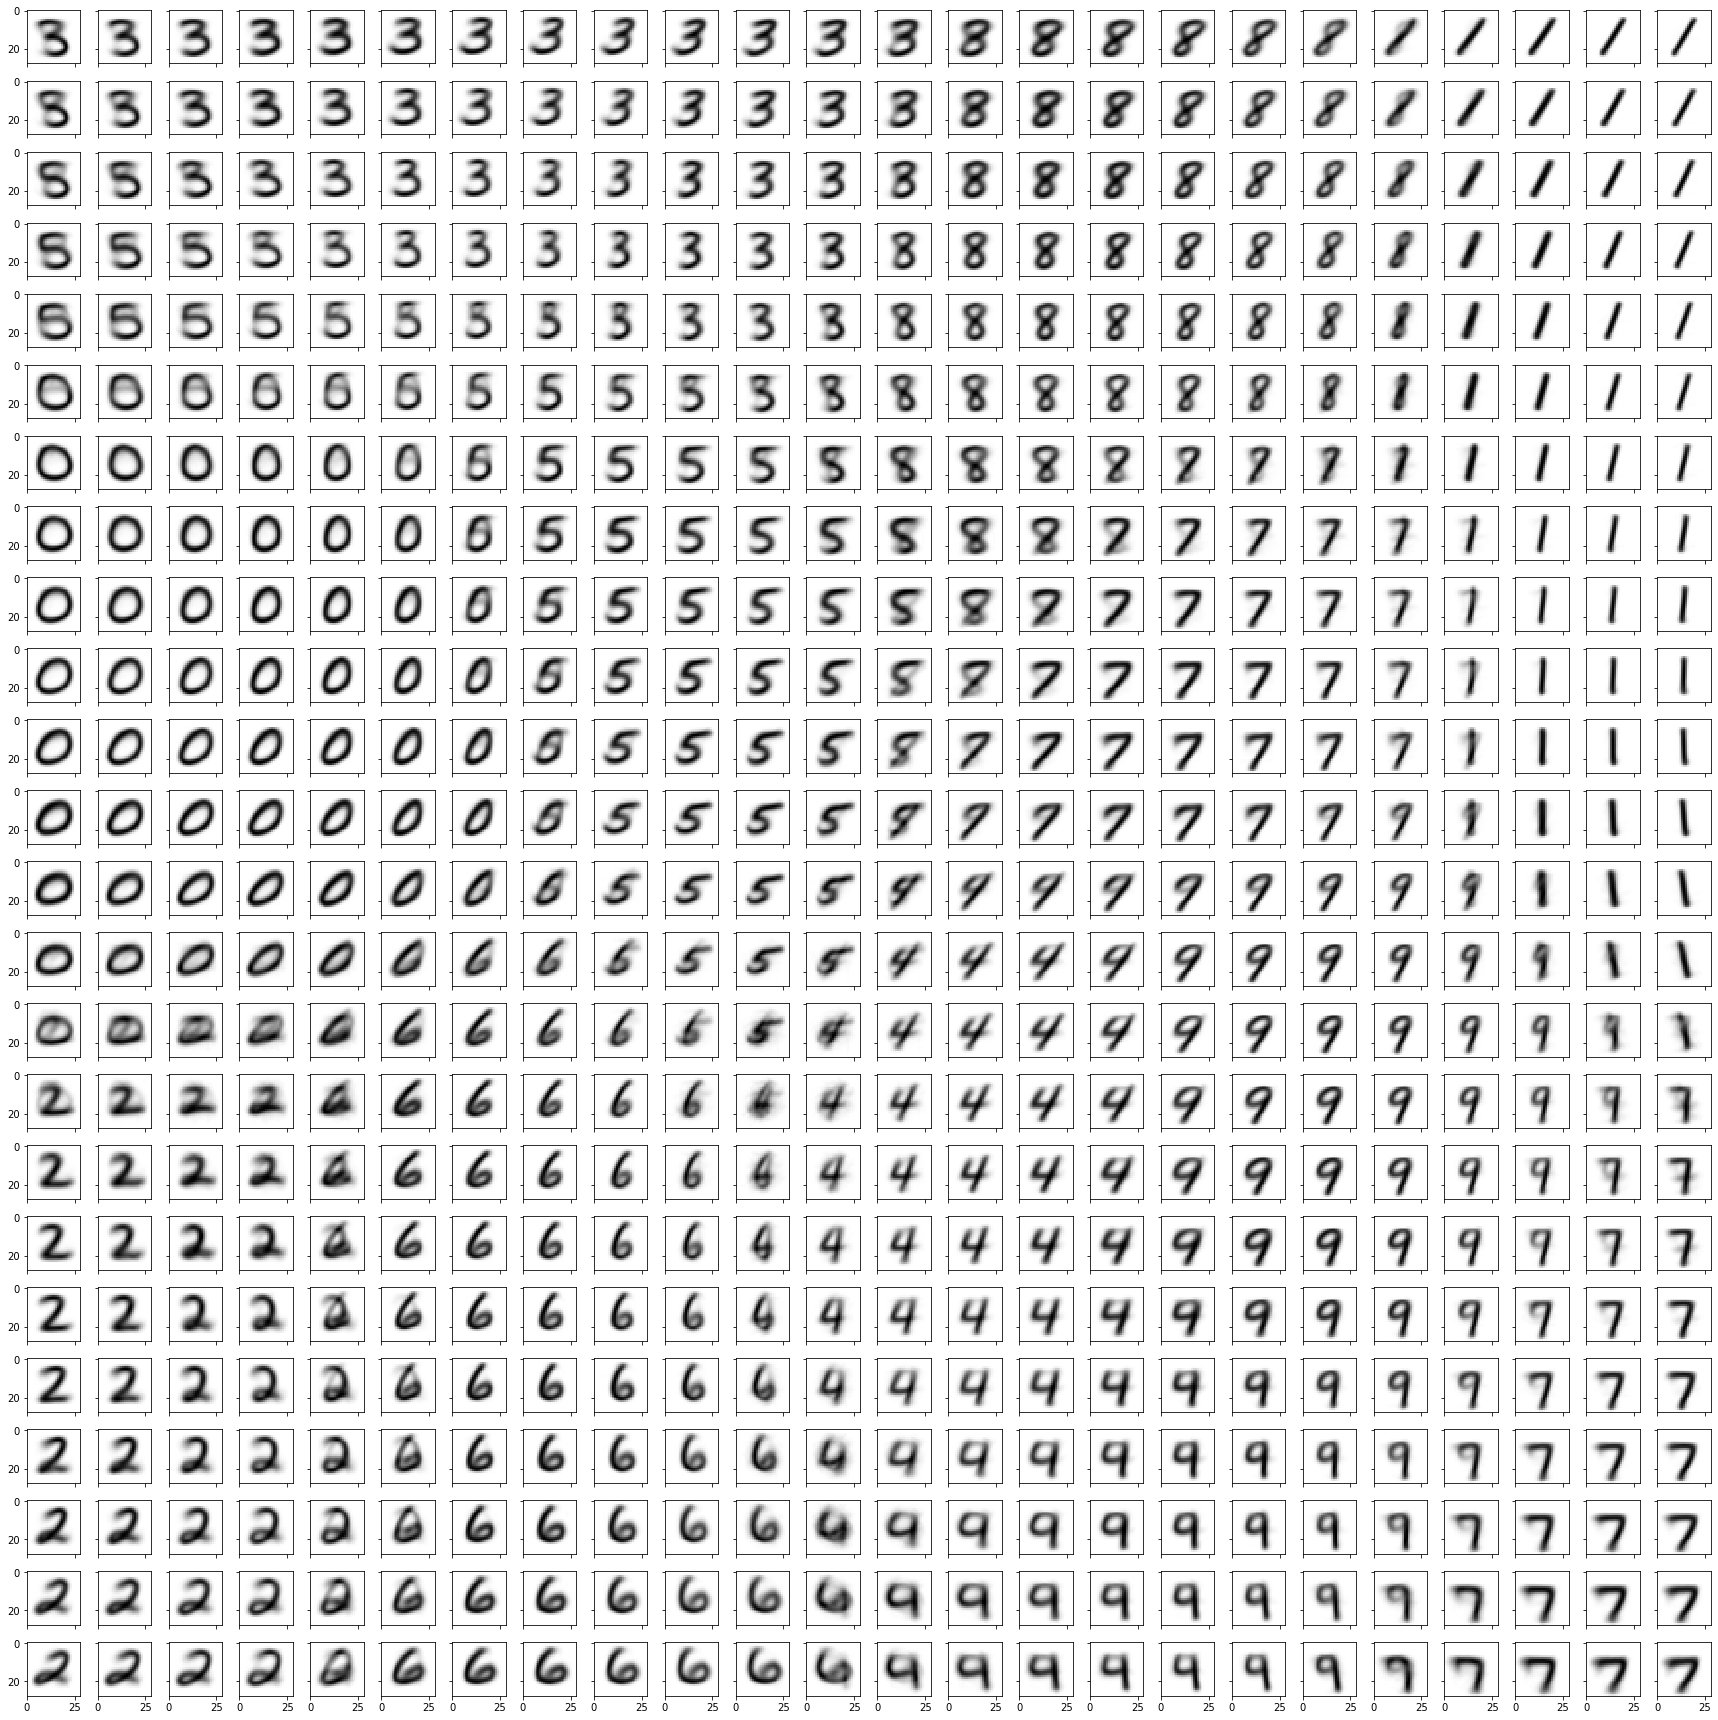

In [0]:
weight_developed = som_24x24.get_weights().reshape(24*24,28,28).copy()
ig, axes = plt.subplots(24,24, 
                         figsize=(24,24),
                         sharex=True, sharey=True)

for i in range(24*24):
    
    # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
    subplot_row = i//24 
    subplot_col = i%24  
    ax = axes[subplot_row, subplot_col]

    # plot image on subplot
    plottable_image = weight_developed[i]
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

# Entropy Heatmap

In [0]:
def dict_for_entropy(som, X, y):
  dict_winner_neuron = {}
  for i in range(10):
    x_i = y==str(i)
    for x, t in zip(X[x_i], y[x_i]):  # scatterplot
        w = som.winner(x)
        if w not in dict_winner_neuron:
          dict_winner_neuron[w] = {}
          if i not in dict_winner_neuron[w]:
            dict_winner_neuron[w][i] = 1
        elif i not in dict_winner_neuron[w]:
          dict_winner_neuron[w][i] = 1
        else:
          dict_winner_neuron[w][i] += 1
  return dict_winner_neuron

In [0]:
import plotly.express as px

def heatmap_entropy(dict_winner_neuron, size):
  map_132 = pd.DataFrame(np.zeros((size, size)), index=range(0,size), columns=range(0,size))
  for i in dict_winner_neuron:
      _sum_winner_neuron = sum(dict_winner_neuron[i].values())
      digits = list(dict_winner_neuron[i].values())
      map_132[i[0]][i[1]] = sum([-(j/_sum_winner_neuron)*np.log(j/_sum_winner_neuron) for j in digits])
    
  if size<12:
    z_text = np.around(map_132.values, decimals=3)
    fig = ff.create_annotated_heatmap(z = map_132.values, annotation_text=z_text, colorscale='hot', showscale=True, zmin=0, zmax=2, reversescale=True)
    fig.update_layout(
      autosize=False,
      width= 75*size if 75*size < 900 else 900 ,
      height=75*size if 75*size < 900 else 900)
    fig.show()
  else:
      num = list(range(1, size+1))
      fig1 = go.Figure(data=go.Heatmap(z=map_132.values, x=[], y=[], colorscale='hot', showscale=True, zmin=0, zmax=2, reversescale=True ))
      fig1.update_layout(
        autosize=False,
        width=900 ,
        height=900)
      fig1.show()


In [0]:
dict_winner_neuron = dict_for_entropy(som_24x24, X, y)
print(dict_winner_neuron)
heatmap_entropy(dict_winner_neuron, 24)

{(10, 3): {0: 127, 2: 1}, (10, 6): {0: 109, 2: 9, 3: 1, 6: 2, 8: 3}, (10, 5): {0: 107, 6: 2}, (9, 2): {0: 121, 2: 2, 9: 1}, (6, 1): {0: 116, 9: 1}, (5, 0): {0: 126, 3: 1, 5: 4, 6: 2, 8: 4, 9: 1}, (8, 5): {0: 143, 6: 1, 9: 1}, (6, 2): {0: 128, 2: 1, 6: 2}, (9, 5): {0: 113, 2: 1, 6: 1}, (6, 0): {0: 178, 5: 1, 6: 3, 8: 1}, (12, 0): {0: 217, 9: 1}, (8, 3): {0: 139, 8: 1, 9: 1}, (11, 3): {0: 121, 2: 2, 8: 1}, (8, 0): {0: 193}, (12, 1): {0: 77, 2: 1, 6: 1}, (8, 4): {0: 124, 2: 1, 9: 1}, (7, 0): {0: 174, 9: 1}, (6, 4): {0: 119, 2: 3}, (6, 5): {0: 99, 2: 1, 5: 3, 6: 6, 8: 2}, (19, 10): {0: 2, 2: 4, 3: 1, 4: 11, 5: 7, 6: 59, 8: 1, 9: 1}, (14, 0): {0: 73, 2: 2, 3: 5, 5: 6, 6: 19, 8: 3, 9: 4}, (7, 1): {0: 109, 8: 1}, (8, 2): {0: 136}, (7, 3): {0: 127}, (7, 5): {0: 156, 2: 1, 6: 3, 9: 1}, (11, 4): {0: 123, 5: 1, 8: 1}, (10, 4): {0: 131, 2: 1, 8: 1}, (8, 1): {0: 95, 8: 2}, (11, 2): {0: 130, 2: 4}, (7, 2): {0: 111, 2: 2, 8: 1, 9: 4}, (12, 2): {0: 143, 6: 1}, (13, 2): {0: 77, 2: 2, 3: 2, 6: 5, 7: 2, 

# Normalized Metric

In [0]:
def m_xy(winner_neurons_dict):
  return_dict = {}
  for i in winner_neurons_dict.keys():
    x = 0 
    for j in winner_neurons_dict[i].keys():
      x += winner_neurons_dict[i][j]
    return_dict[i] = x
  return return_dict
    

In [0]:
def normalized_metric(winner_neurons_dict, num_elements_per_class):
  m_xy1 = m_xy(winner_neurons_dict)
  return_dict, p_xy, q_xy, pq_xy = {}, {}, {}, {}
  for i in winner_neurons_dict.keys():
    if i not in p_xy:
      p_xy[i] = {}
    if i not in q_xy:
      q_xy[i] = {}
    if i not in pq_xy:
      pq_xy[i] = {}
    for j in winner_neurons_dict[i].keys():
      if j not in p_xy:
        p_xy[i][j] = float(winner_neurons_dict[i][j])/float(num_elements_per_class[j])
      if j not in q_xy:
        q_xy[i][j] = float(winner_neurons_dict[i][j])/float(m_xy1[i])
      if j not in pq_xy:
        pq_xy[i][j] = p_xy[i][j]*q_xy[i][j]
      if j not in return_dict:
        return_dict[j] = pq_xy[i][j]
      return_dict[j] += pq_xy[i][j]
  ret_val = 0
  for i in return_dict:
    ret_val += return_dict[i]
  return ret_val/len(return_dict.keys())


In [0]:
num_elements_per_class_train = {}
num_elements_per_class_test = {}
for j in range(10):
  x = 0
  for i in y_train==str(j):
    if i:
      x += 1
  num_elements_per_class_train[j]=x
  x = 0
  for i in y_test==str(j):
    if i:
      x += 1
  num_elements_per_class_test[j]=x

In [0]:
X_train = X[:60000];
X_test = X[60000:70000];
X_7_train = X_7_train.reshape(60000,7*7); 
X_14_train = X_14_train.reshape(60000,14*14);
X_train = X_train.reshape(60000,28*28);
X_test = X_test.reshape(10000,28*28);

X_7_test = X_7[60000:70000]; 
X_14_test = X_14[60000:70000]; 
X_7_test = X_7_test.reshape(10000,7*7); X_14_test = X_14_test.reshape(10000,14*14);


In [0]:
dict_winner_neuron_train = dict_for_entropy(som_24x24,  X_train,  y_train)
dict_winner_neuron_test  = dict_for_entropy(som_24x24,  X_test,   y_test)

In [0]:
dict_6x6_train = dict_for_entropy(som_6x6,  X_7_train,  y_train)
dict_6x6_test = dict_for_entropy(som_6x6,  X_7_test,  y_test)

In [0]:
dict_12x12_train = dict_for_entropy(som_12x12,  X_14_train,  y_train)
dict_12x12_test = dict_for_entropy(som_12x12,  X_14_test,  y_test)

In [0]:
print(normalized_metric(dict_6x6_train, num_elements_per_class_train), 
      normalized_metric(dict_6x6_test, num_elements_per_class_test))
print(normalized_metric(dict_12x12_train, num_elements_per_class_train), 
      normalized_metric(dict_12x12_test, num_elements_per_class_test))


0.38898808688716463 0.4093566784170187
0.6656184581066431 0.6748131519793835


In [0]:
print(normalized_metric(dict_winner_neuron_train, num_elements_per_class_train), 
      normalized_metric(dict_winner_neuron_test, num_elements_per_class_test))

0.8184199380406605 0.8375859158049874


# **Classification Metrics**

For each neuron, assign it the class it gets activated, this will be a dict,

with key - as tuple (x, y) of the location of neuron on the grid, whereas, value will be the class value for which it gets activated the most

---

Now, traverse through X_test and 

create two lists y_true and y_pred depending 

on the location on the grid (x, y) where the X_test gets activated

---

Get the confusion matrix, accuracy, precision and recall values

In [0]:
def majority_class_neuron(winner_neuron_dict):
  majority_dict = {}
  for location in winner_neuron_dict:
    majority_dict[location] = max(winner_neuron_dict[location], key=winner_neuron_dict[location].get)
  return majority_dict

In [0]:
def classification_metric(winner_neuron_dict, som, X_test):
  y_pred = []
  majority_class_nron = majority_class_neuron(winner_neuron_dict)
  for x_i in X_test:
    location = som.winner(x_i)
    y_pred.append(str(majority_class_nron[location]))
  return y_pred


In [0]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.metrics import accuracy_score as accuracy

y_pred_som = classification_metric(dict_winner_neuron_test, som_24x24, X_test)
print(cm(y_test, y_pred_som), '\n', cr(y_test, y_pred_som), '\n', accuracy(y_test, y_pred_som))

[[ 953    1    6    0    1    8    8    1    2    0]
 [   0 1121    3    2    1    0    5    1    2    0]
 [  14   10  935   17    6    1    8   15   24    2]
 [   6    1   17  886    4   44    3   19   23    7]
 [   3    6   17    0  802    1   15    5    0  133]
 [  17    1    6   49    8  775    8    5   17    6]
 [  20    3    5    0    5    7  916    0    1    1]
 [   0   20   15    1   14    0    0  928    5   45]
 [  19    2   20   56    9   66    5    7  781    9]
 [   7    3    7    9  145    7    3   38   10  780]] 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.96      0.99      0.97      1135
           2       0.91      0.91      0.91      1032
           3       0.87      0.88      0.87      1010
           4       0.81      0.82      0.81       982
           5       0.85      0.87      0.86       892
           6       0.94      0.96      0.95       958
           7       0.91      0.90 

In [0]:
def confusion_matrix_training(dict_winner):
  confusion_matrix = [[0 for i in range(10)] for j in range(10)]
  majority_class_nron = majority_class_neuron(dict_winner)
  for location in dict_winner:
    i = majority_class_nron[location]
    for j in dict_winner[location]:
      confusion_matrix[i][j] += dict_winner[location][j]
  i, j = 0, 0
  num, den = 0, 0
  for i in range(10):
    for j in range(10):
      if i==j:
        num += confusion_matrix[i][j]
      else:
        den += confusion_matrix[i][j]
      
  print(num/(num+den), confusion_matrix)
  return
    

In [0]:
print(confusion_matrix_training(dict_winner_neuron_train))

0.87985 [[5667, 0, 66, 33, 5, 55, 96, 7, 46, 33], [0, 6598, 71, 40, 38, 18, 13, 58, 68, 13], [27, 32, 5355, 114, 41, 34, 23, 71, 93, 44], [5, 11, 43, 5161, 1, 178, 0, 1, 229, 84], [16, 16, 92, 44, 4730, 79, 29, 104, 92, 947], [59, 5, 24, 346, 4, 4776, 87, 9, 488, 34], [120, 21, 59, 38, 83, 115, 5664, 18, 41, 12], [1, 20, 114, 103, 31, 13, 0, 5627, 33, 248], [25, 25, 122, 216, 5, 115, 6, 19, 4706, 27], [3, 14, 12, 36, 904, 38, 0, 351, 55, 4507]]
None


In [0]:
y_test_cm_6x6 = classification_metric(dict_6x6_test, som_6x6, X_7_test)
print(cm(y_test, y_test_cm_6x6), '\n', cr(y_test, y_test_cm_6x6), '\n', accuracy(y_test, y_test_cm_6x6))

[[ 750    3   34   38    2   76   50   17   10    0]
 [   0 1044    6    4    2   17    4    9   49    0]
 [  48   42  417  106   24   70   92   72  158    3]
 [   3   25   58  466   21  112   42  126  138   19]
 [   1   46   17    0  163   18  128  195   52  362]
 [  21  119   23  225   31  175   69  115   86   28]
 [  38   44   78   32   33   47  605   49   32    0]
 [   4   94   28    1   26   57   12  417   89  300]
 [  15   56  175  163   40   67   64   72  309   13]
 [   8   49   21    4   77   34   49  221   65  481]] 
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       980
           1       0.69      0.92      0.79      1135
           2       0.49      0.40      0.44      1032
           3       0.45      0.46      0.45      1010
           4       0.39      0.17      0.23       982
           5       0.26      0.20      0.22       892
           6       0.54      0.63      0.58       958
           7       0.32      0.41 

In [0]:
print(confusion_matrix_training(dict_6x6_train))

0.4582833333333333 [[4485, 0, 231, 59, 7, 171, 126, 28, 85, 49], [18, 6196, 240, 202, 249, 866, 409, 567, 602, 412], [301, 15, 2240, 393, 83, 97, 621, 100, 1230, 119], [311, 38, 1163, 3388, 9, 1517, 261, 123, 1437, 121], [13, 13, 147, 162, 918, 184, 239, 189, 181, 459], [326, 1, 99, 264, 1, 487, 58, 14, 109, 9], [278, 14, 755, 371, 879, 619, 3407, 70, 444, 293], [105, 141, 572, 842, 1900, 969, 462, 3239, 409, 2164], [73, 309, 432, 289, 269, 331, 262, 488, 1218, 404], [13, 15, 79, 161, 1527, 180, 73, 1447, 136, 1919]]
None


In [0]:
y_test_cm_12x12 = classification_metric(dict_12x12_test, som_12x12, X_14_test)
print(cm(y_test, y_test_cm_12x12), '\n', cr(y_test, y_test_cm_12x12), '\n', accuracy(y_test, y_test_cm_12x12))

[[ 868    1    6    5    6   15   73    1    4    1]
 [   0 1107   11    0    0    1    3    2   11    0]
 [  17   22  860   29   18    7   24   27   28    0]
 [   5   34   32  767    3   51    5   28   81    4]
 [   1    9   16    1  692   18   25   16    3  201]
 [  23    5   19  313   34  387   39   19   34   19]
 [  13    5   17    5   23    9  880    0    6    0]
 [   1   32   19    5   28    6    2  860   18   57]
 [  21   17   26   98   30   45   17   25  681   14]
 [   9    8    8   11  275    2    7  132    8  549]] 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.89      0.98      0.93      1135
           2       0.85      0.83      0.84      1032
           3       0.62      0.76      0.68      1010
           4       0.62      0.70      0.66       982
           5       0.72      0.43      0.54       892
           6       0.82      0.92      0.87       958
           7       0.77      0.84 

In [0]:
print(confusion_matrix_training(dict_12x12_train))

0.7527 [[5372, 0, 207, 106, 19, 159, 187, 15, 84, 42], [1, 6504, 113, 190, 44, 52, 59, 156, 119, 46], [14, 77, 4762, 174, 47, 58, 132, 59, 148, 21], [34, 11, 185, 4520, 20, 1995, 33, 4, 517, 83], [9, 1, 131, 64, 4210, 228, 134, 233, 150, 1816], [139, 13, 128, 213, 208, 2418, 143, 53, 608, 73], [279, 10, 129, 40, 109, 141, 5188, 16, 58, 41], [2, 11, 90, 99, 49, 34, 0, 5051, 57, 589], [68, 102, 171, 566, 28, 185, 41, 96, 3948, 49], [5, 13, 42, 159, 1108, 151, 1, 582, 162, 3189]]
None
